In [1]:
import wandb

In [2]:
wandb.init(project="lunarLander(scheduler)", entity = "rl_proj")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1630423 (rl_proj). Use `wandb login --relogin` to force relogin


In [3]:
import gymnasium as gym
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.optim.lr_scheduler import StepLR

os.makedirs("outputs", exist_ok=True)

DEVICE = "cpu"
ACTION_SPACE = [0, 1, 2, 3]
EPISODES = 8000
BATCH_SIZE = 8
GAMMA = 0.99
RENDER = False
SAVE_INTERVAL = 100  # Save model every 100 episodes
PRINT_INTERVAL = 100  # Print information every 50 episodes
MAX_STEPS_PER_EPISODE = 100 #maximum steps for each episode

class ReinforceNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(ReinforceNetwork, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, n_outputs)

    def forward(self, x):
        x = x.unsqueeze(0) if x.dim() == 1 else x
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        actions = torch.softmax(self.fc3(x), dim=-1)
        action = self.get_action(actions)
        log_prob_action = torch.log(actions.squeeze(0))[action]
        return action, log_prob_action

    def get_action(self, actions):
        return np.random.choice(ACTION_SPACE, p=actions.squeeze(0).detach().cpu().numpy())

env = gym.make("LunarLander-v2")
model = ReinforceNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)

all_rewards = []
all_losses = []
batch_rewards = []
batch_log_probs = []
best_rolling = -99999

for episode in range(EPISODES):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=DEVICE)  # Convert state to tensor
    episode_rewards = []
    episode_log_probs = []

    for step in range(MAX_STEPS_PER_EPISODE):
        if RENDER:
            env.render()

        action, log_prob = model(state)
        step_result = env.step(action)
        state, reward, done, info = step_result[:4]
        state = torch.tensor(state, dtype=torch.float32, device=DEVICE)  # Convert next state to tensor

        episode_log_probs.append(log_prob)
        episode_rewards.append(reward)  

        if done:

          break

    total_reward = np.sum(episode_rewards)
    all_rewards.append(total_reward)
    rolling_avg_reward = pd.Series(all_rewards).tail(100).mean()

    if (episode + 1) % PRINT_INTERVAL == 0:

        print(f"EPISODE {episode} SCORE: {total_reward} roll: {rolling_avg_reward}")

    if rolling_avg_reward > best_rolling:
        best_rolling = rolling_avg_reward
        #print("Saving model...")
        torch.save(model.state_dict(), f'/workspaces/RL_Project/LunarLander/outputs/best_parameters_scheduler.pth')

    batch_rewards.extend(episode_rewards)
    batch_log_probs.extend(episode_log_probs)

    if (episode + 1) % BATCH_SIZE == 0 or episode == EPISODES - 1:
        discounted_rewards = []
        Gt = 0
        for reward in reversed(batch_rewards):
            Gt = reward + GAMMA * Gt
            discounted_rewards.insert(0, Gt)

        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32, device=DEVICE)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        batch_log_probs = torch.stack(batch_log_probs)

        policy_gradient = -batch_log_probs * discounted_rewards

        optimizer.zero_grad()
        loss = policy_gradient.sum()
        loss.backward()
        optimizer.step()

        scheduler.step()

        all_losses.append(loss.item())
        batch_rewards = []
        batch_log_probs = []


env.close()


EPISODE 99 SCORE: -71.05779216850716 roll: -138.56725535194497
EPISODE 199 SCORE: -150.25557179671864 roll: -134.5076921611176
EPISODE 299 SCORE: 25.615344847046913 roll: -81.64236761033622
EPISODE 399 SCORE: -24.222504726594856 roll: -49.02278094049685
EPISODE 499 SCORE: -12.850934378266885 roll: -28.71323184580454
EPISODE 599 SCORE: 20.593846876711766 roll: 2.683452802689538
EPISODE 699 SCORE: 96.60264856451579 roll: 35.55127031730706
EPISODE 799 SCORE: 118.20216204040138 roll: 50.32140622607482
EPISODE 899 SCORE: 19.594955484551807 roll: 35.51326500110389
EPISODE 999 SCORE: 87.38366017622364 roll: 51.29926234968082
EPISODE 1099 SCORE: 100.09327836240303 roll: 64.51626941009071
EPISODE 1199 SCORE: 109.47514321391809 roll: 74.54944151634727
EPISODE 1299 SCORE: 99.57367655305625 roll: 81.81494412880413
EPISODE 1399 SCORE: 72.72876027684967 roll: 78.93473868190759
EPISODE 1499 SCORE: 71.91332920112804 roll: 80.02585648598799
EPISODE 1599 SCORE: 78.07028889700472 roll: 82.58846503446588


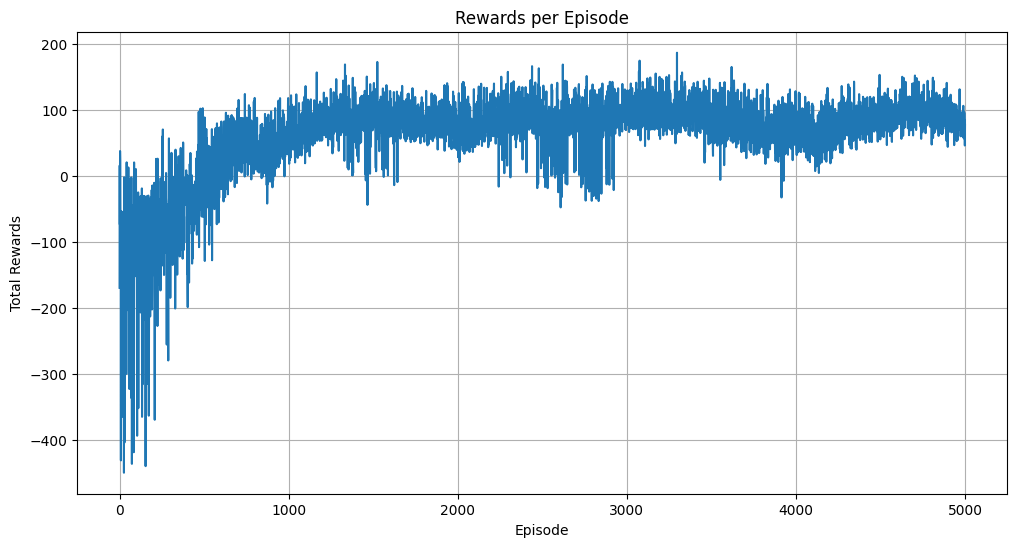

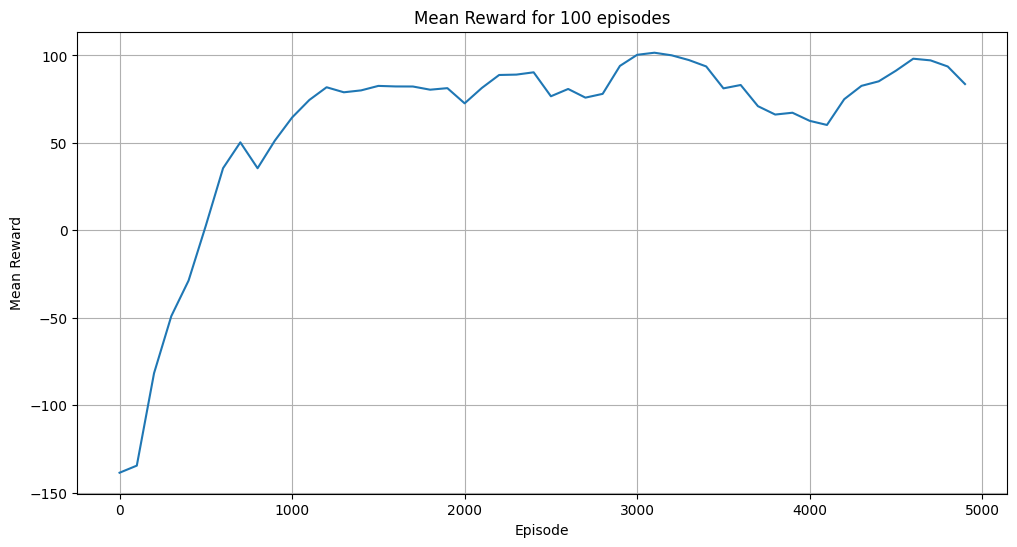

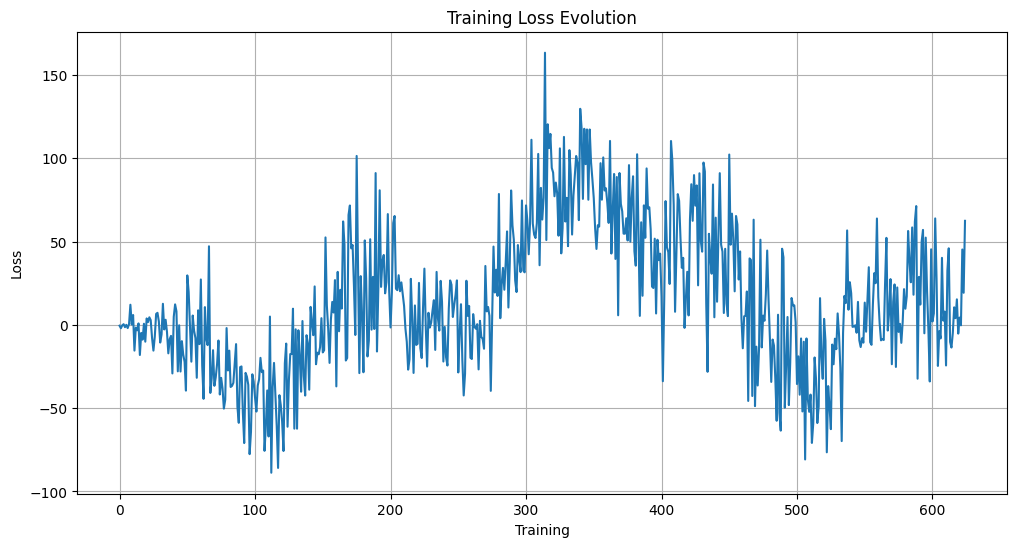

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(all_rewards)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Rewards")
plt.grid()

# Log the plot to wandb
wandb.log({"Rewards per Episode": wandb.Image(plt)})
plt.show()

# Graficar la evolución de las recompensas promedio cada 100 episodios
average_rewards = [pd.Series(all_rewards).iloc[i:i+100].mean() for i in range(0, len(all_rewards), 100)]
plt.figure(figsize=(12, 6))
plt.plot(range(0, len(all_rewards), 100), average_rewards)
plt.title("Mean Reward for 100 episodes")
plt.xlabel("Episode")
plt.ylabel("Mean Reward")
plt.grid()

# Log the plot to wandb
wandb.log({"Mean Reward for 100 Episodes": wandb.Image(plt)})
plt.show()

# Graficar la evolución de la pérdida a lo largo del entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(all_losses)
plt.title("Training Loss Evolution")
plt.xlabel("Training")
plt.ylabel("Loss")
plt.grid()

# Log the plot to wandb
wandb.log({"Training Loss Evolution": wandb.Image(plt)})
plt.show()

wandb.finish()